In [ ]:
from pathlib import Path

PROTEIN_CLS = "GFP"

WD = Path(f"CR/{PROTEIN_CLS}")
WD.mkdir(parents=True, exist_ok=True)

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from time import sleep
from selenium.webdriver.common.by import By
from selenium import webdriver


def consurf(sid):
    # prepare sequences
    seq_path = Path(f"../data/{PROTEIN_CLS}/generated/Q/{sid}.fasta")
    seqs_path = WD / f"{sid}.fasta"
    seqs = [SeqIO.read(seq_path, "fasta")]
    for _, ref in pd.read_csv(
            f"../data/{PROTEIN_CLS}_ref.csv"
    ).drop_duplicates(subset=['Entry ID'], keep='first').iterrows():
        seqs.append(SeqRecord(Seq(ref["Sequence"]), id=ref["Entry ID"], description=""))
    with open(seqs_path, "w") as f:
        SeqIO.write(seqs, f, format="fasta")

    # alignment
    aln_path = WD / f"{sid}.aln.fasta"
    !clustalo -i {seqs_path} -o {aln_path} --outfmt=fa

    # run consurf
    pdb_path = Path(f"/home/tz365/WS/ProtMatch/data/{PROTEIN_CLS}/generated/BQ/{sid}.pdb")

    driver = webdriver.Chrome()
    driver.get('https://consurf.tau.ac.il/consurf_index.php')

    # PAGE 1
    driver.find_element(By.ID, 'browse').send_keys(str(pdb_path))
    driver.find_element(By.ID, 'JOB_TITLE').send_keys(f"{pdb_path.stem}({PROTEIN_CLS})")
    driver.find_element(By.ID, 'user_email').send_keys("ecburxvip@gmail.com")
    sleep(2)
    driver.find_element(By.XPATH, "//input[@value='Select Run Parameters Manually']").click()

    # PAGE 2
    driver.find_element(By.ID, 'browse1').send_keys(str(aln_path.absolute()))
    sleep(5)
    driver.find_element(By.ID, 'drop_col').click()
    driver.find_element(By.ID, 'drop_col').find_element(By.XPATH, f"//li[@data-value='{sid}']").click()
    driver.find_element(By.XPATH, "//input[@value='Submit']").click()

    # PAGE 3
    url = driver.current_url
    print(f"'{sid}': '{url}',")
    driver.close()
    return url

In [ ]:
urls = {
    (sid := f"SM_{i}"): consurf(sid)
    for i in range(0, 50)
}
urls

In [ ]:
# urls = {
# }

def retrieve(sid, url):
    driver = webdriver.Chrome()
    driver.get(url)
    driver.find_element(By.LINK_TEXT, "Go To The Results").click()
    sleep(2)
    driver.find_element(By.XPATH, f"//a[contains(@href, '{sid}_consurf_grades.txt')]").click()
    sleep(5)
    driver.close()


for k, v in urls.items():
    retrieve(k, v)

In [11]:
import pandas as pd
import re
from pathlib import Path

PROTEIN_CLS = "RAS"

Path(f"CR2/{PROTEIN_CLS}").mkdir(parents=True, exist_ok=True)

for src in Path(f"CR/{PROTEIN_CLS}").glob("*.txt"):
    dst = f"CR2/{PROTEIN_CLS}/{src.name}"
    with open(src, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    with open(dst, 'w', encoding='utf-8') as f:
        f.writelines(lines[29:len(lines) - 4])

In [137]:
Path(f"../data/{PROTEIN_CLS}/generated/C/").mkdir(parents=True, exist_ok=True)

for path in Path(f"CR2/{PROTEIN_CLS}").glob("*.txt"):
    data = []
    start = False
    with open(path, 'r') as f:
        for line in f:
            parts = line.split()
            pos = parts[0]
            seq = parts[1]
            atom = parts[2]
            score = float(parts[3])
            color = int(re.findall(r'\d+', parts[4])[0])
            confidence_interval = (
                float(parts[5].split(',')[0]), float(parts[6]), *[int(i) for i in parts[7].split(",")])
            be = parts[8]
            if parts[9] == "f" or parts[9] == "s":
                fs = parts[9]
                msa_data = parts[10]
                residue_variety = " ".join(parts[11:])
            else:
                fs = ""
                msa_data = parts[9]
                residue_variety = " ".join(parts[10:])
            data.append([pos, seq, atom, score, color, confidence_interval, be, fs, msa_data, residue_variety])

        pd.DataFrame(
            data,
            columns=[
                "POS", "SEQ", "ATOM", "SCORE", "COLOR",
                "CONFIDENCE_INTERVAL", "B/E", "F/S", "MSA DATA", "RESIDUE_VARIETY"
            ]).to_csv(f"../data/{PROTEIN_CLS}/generated/C/{path.stem}.csv", index=False)

aa 170


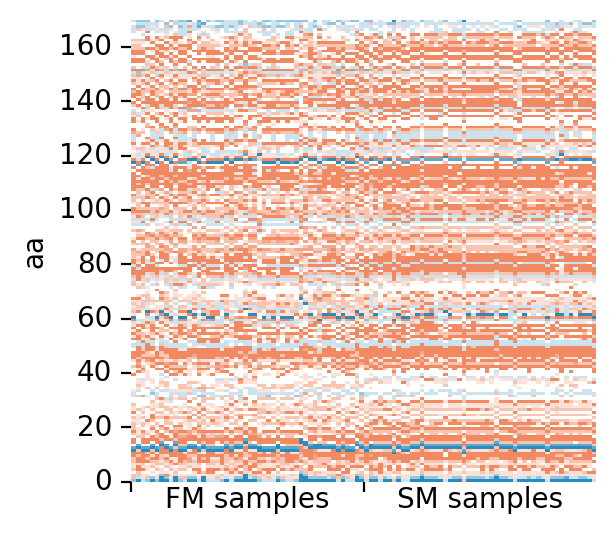

In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import src.colorscheme as color

PROTEIN_CLS = "RAS"

aa = 0
conserve_grades = []
for csv in sorted(Path(f"../data/{PROTEIN_CLS}/generated/C/").glob("*.csv")):
    df = pd.read_csv(csv)
    aa = df.shape[0]
    conserve_grades.append(df["COLOR"].values)
print("aa", aa)
conserve_grades = np.column_stack(conserve_grades)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.heatmap(conserve_grades,
            cbar=False,
            cmap=mcolors.LinearSegmentedColormap.from_list("cmap", [color.CS_FG_B, "white", color.CS_FG_A]))
ax.text(0.25, -0.07, 'FM samples', transform=ax.transAxes, ha='center', va='bottom')
ax.text(0.75, -0.07, 'SM samples', transform=ax.transAxes, ha='center', va='bottom')
plt.xticks(ticks=np.arange(0, 100, 50))
plt.yticks(ticks=np.arange(0, aa, 20), labels=[f'{i}' for i in range(0, aa, 20)])
plt.gca().invert_yaxis()
plt.ylabel('aa')
plt.show()

([], [])

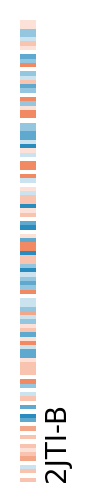

In [188]:
data = []
start = False
sid = "2JTI"

with open(f"CR/exp/{sid}.txt", 'r') as f:
    for line in f:
        parts = line.split()
        pos = parts[0]
        seq = parts[1]
        atom = parts[2]
        score = parts[3]
        color = int(re.findall(r'\d+', parts[4])[0])
        data.append([pos, seq, atom, score, color])

    pd.DataFrame(
        data,
        columns=[
            "POS", "SEQ", "ATOM", "SCORE", "COLOR",
        ]).to_csv(f"CR/exp/{sid}.csv", index=False)

import matplotlib.colors as mcolors
import src.colorscheme as color

df = pd.read_csv(f"CR/exp/{sid}.csv")

fig, ax = plt.subplots(figsize=(0.1, 3), dpi=200)
sns.heatmap(df["COLOR"].values.reshape(1,-1).T,
            cbar=False,
            cmap=mcolors.LinearSegmentedColormap.from_list("cmap", [color.CS_FG_B, "white", color.CS_FG_A])
            )
ax.text(1.5, 0, f'{sid}-B', transform=ax.transAxes, ha='left', va='bottom', rotation=90, fontsize=10)
plt.xticks([])
plt.yticks([])

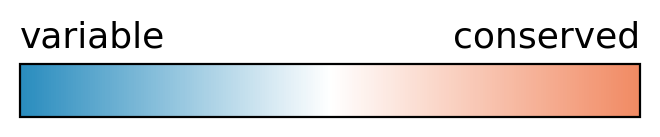

In [182]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(4, 0.7), dpi=200)
fig.subplots_adjust(bottom=0.5)

cmap = mcolors.LinearSegmentedColormap.from_list("ramachandran_cmap", [color.CS_FG_B, "white", color.CS_FG_A])
norm = mpl.colors.Normalize(vmin=0, vmax=9)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_ticks([])
cb.ax.text(0, 1.2, 'variable', transform=cb.ax.transAxes, ha='left', va='bottom', fontsize=13)
cb.ax.text(1.0, 1.2, 'conserved', transform=cb.ax.transAxes, ha='right', va='bottom', fontsize=13)
plt.show()